In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [5]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [6]:
parent_llm = ChatOpenAI(model='gpt-4o-mini')
subgraph_llm = ChatOpenAI(model='gpt-4o')

In [7]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

In [10]:
subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [11]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [12]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

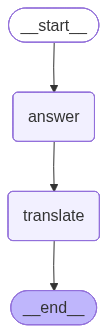

In [13]:
graph = parent_builder.compile()

graph

In [14]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': "Quantum physics, also known as quantum mechanics, is a fundamental branch of physics that deals with the behavior of matter and energy at very small scales, typically at the level of atoms and subatomic particles. It describes phenomena that classical physics cannot explain, such as the wave-particle duality of particles, quantization of energy levels, and the uncertainty principle.\n\nKey principles of quantum physics include:\n\n1. **Wave-Particle Duality**: Particles, such as electrons and photons, exhibit both wave-like and particle-like properties, depending on the experiment being conducted.\n\n2. **Superposition**: A quantum system can exist in multiple states simultaneously until it is observed or measured, at which point it 'collapses' into one of the possible states.\n\n3. **Entanglement**: Particles can become entangled, meaning the state of one particle is directly related to the state of another, regardless of the dis